## Overview: CatBoost-Based Model Development Pipeline


This notebook outlines the step-by-step development process of a **CatBoost-based machine learning pipeline** for clinical prediction of gram stain bacteremia. It includes the full training flow, feature selection, evaluation, and optional hyperparameter tuning.

> ⚠️ **Due to hospital data confidentiality agreements**, we are unable to share the original datasets.  
> As a result, this notebook is **not directly executable**.  
> Instead, it is provided for transparency and reproducibility—demonstrating how each part of the model was developed and evaluated.

Although the full model cannot be executed without access to the original dataset, we have provided **stored model outputs** so that the following parts can still be executed:

- AUROC and AUPRC plots  
- Calibration plots  
- Performance logs from the feature selection process

These outputs allow users to review the model's prediction performance and the feature elimination procedure, even without direct access to original data.


---

## Workflow Summary

1. **Library**  
   Import required packages and modules.

2. **Settings**  
   Define project paths, parameters, and global variables.

3. **Assign Variables**  
   Load feature sets and label mappings.

4. **Start Training**
   - Data preprocessing  
   - Train initial CatBoost model  
   - Train baseline model for comparison  

5. **Feature Selection**
   - Perform backward feature elimination  
   - Select feature subsets based on AUROC  
   - **Able to view selection logs**.

6. **Model Performance with Specific Feature Number**  
   Evaluate performance at each stage of feature selection.

7. **Hyperparameter Tuning**  
   (Optional) Use `RandomizedSearchCV` to optimize CatBoost parameters.

8. **Final Model**  
   Retrain the model using optimal features and parameters.

9. **Plot** (***Executable***)  
   Generate evaluation plots:
   - AUROC (Receiver Operating Characteristic)  
   - AUPRC (Precision-Recall Curve)  
   - Calibration curves


## **Library**

In [31]:
# ========= Basic Utilities and System Setup =========
import os
import sys

# ========= Data Handling =========
import numpy as np
import pandas as pd
from scipy.stats import uniform, randint
from joblib import load

# ========= Machine Learning =========
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

# ========= Tools and Visualization =========
from tqdm import tqdm

# ========= Custom Modules =========

# Add custom module path
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
sys.path.insert(0, src_path)

from config import data_dir, cache_dir
from model_utils import (
    custom_classify,
    get_metrics,
    imputer,
    scaling,
    find_classwise_thresholds_by_youden,
    backward_feature_selection,
    clean_checkpoints,
    list_checkpoints,
    plot_multiclass_roc,
    plot_multiclass_prc,
    plot_combined_calibration_curve
)


## **Settings**

In [ ]:
random_seed= 564
impute_method = 'mean'
class_weights = {0: 1, 1: 1, 2:1}

## **Assign Variables**

In [11]:
# Load data 
data_train = pd.read_csv(
    os.path.join(data_dir, 'CMUH_GS_2021_triage.csv'),
)

data_test = pd.read_csv(
    os.path.join(data_dir, 'CMUH_GS_2023_triage.csv'),
)

# Load external validation datasets from AN and WMH hospitals
data_ANH = pd.read_csv(
    os.path.join(data_dir, 'AN_GS_2023.csv'),
)

data_WMH = pd.read_csv(
    os.path.join(data_dir, 'WK_GS_2023.csv'),
)

In [12]:
y = data_train.loc[:,'final_label']
x = data_train.iloc[:,6:93]

y_test = data_test.loc[:,'final_label']
x_test = data_test.iloc[:,6:93]

y_wk = data_WMH.loc[:,'final_label']
x_wk = data_WMH.iloc[:,6:93]

y_an = data_ANH.loc[:,'final_label']
x_an = data_ANH.iloc[:,6:93]

x_base = data_train[['SIRS']]
x_test_base = data_test[['SIRS']]

In [44]:
from collections import Counter

# List of label arrays and their corresponding names
label_sets = [
    ("CMUH development", y),
    ("CMUH validation", y_test),
    ("WMH validation", y_wk),
    ("ANH validation", y_an)
]

for name, y_labels in label_sets:
    element_counts = Counter(y_labels)
    total_elements = len(y_labels)

    print(f"\n=== {name} ===")
    print(f"Total cases: {total_elements}")
    
    for cls in [0, 1, 2]:
        count = element_counts[cls]
        proportion = count / total_elements
        print(f"Class {cls}: {count} ({proportion:.2%})")



=== CMUH development ===
Total cases: 28503
Class 0: 25534 (89.58%)
Class 1: 2174 (7.63%)
Class 2: 795 (2.79%)

=== CMUH validation ===
Total cases: 15801
Class 0: 14387 (91.05%)
Class 1: 997 (6.31%)
Class 2: 417 (2.64%)

=== WMH validation ===
Total cases: 2632
Class 0: 2415 (91.76%)
Class 1: 173 (6.57%)
Class 2: 44 (1.67%)

=== ANH validation ===
Total cases: 3811
Class 0: 3556 (93.31%)
Class 1: 185 (4.85%)
Class 2: 70 (1.84%)


## **Start training**

#### **Data preprocessing**

In [ ]:
# Create a train/validation split using GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_seed)
train_idx, val_idx = next(gss.split(x, y, groups=data_train['ID']))

x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

y_val_bin = label_binarize(y_val, classes=[0, 1, 2])

x_train_imp, m_mean = imputer(x_train, impute_method, train=True)
x_train_scale, train_scaler = scaling(x_train_imp, None, train=True)

x_val_imp = imputer(x_val, impute_method, False, m_mean)
x_val_scale, train_scaler = scaling (x_val_imp, train_scaler, train= False)


#### **Naive Catboost model**

In [36]:
# model fit
model= CatBoostClassifier(verbose=False, class_weights=class_weights)
model.fit(x_train_scale, y_train)

y_prob = model.predict_proba(x_val_scale)

thresholds= find_classwise_thresholds_by_youden(y_val, y_prob)
print("Thresholds for three classes:", [f"{t:.3f}" for t in thresholds])

y_prob_bin = custom_classify(y_prob, thresholds)
y_pred = y_prob_bin.argmax(axis=1)

metrics , cm = get_metrics(y_val, y_pred, y_prob)
metrics

Thresholds for three classes: ['0.927', '0.064', '0.022']


,AUROC,AUPRC,Accuracy,F1 Score,Sensitivity,Specificity,PPV,NPV
Class 0,0.844874,0.974767,0.699090,0.802299,0.683242,0.832237,0.971604,0.238230
Class 1,0.858273,0.397076,0.841148,0.366806,0.595023,0.861775,0.265121,0.962108
Class 2,0.767251,0.095774,0.798810,0.114022,0.445783,0.809369,0.065371,0.979930


#### **Baseline model**

In [42]:
# Create group-aware train/validation split to prevent data leakage from the same ID
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_seed)
train_idx, val_idx = next(gss.split(x_base, y, groups=data_train['ID']))

x_train_base, x_val_base = x_base.iloc[train_idx], x_base.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

# Preprocessing
x_train_base_imp, m_mean = imputer(x_train_base, impute_method, train=True)
x_train_base_scale, train_scaler = scaling(x_train_base_imp, None, train=True)

x_val_base_imp = imputer(x_val_base, impute_method, False, m_mean)
x_val_base_scale, train_scaler = scaling(x_val_base_imp, train_scaler, train=False)

# train Logistic Regression model
lr_model = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=1000)
lr_model.fit(x_train_base_scale, y_train)

y_prob_base = lr_model.predict_proba(x_val_base_scale)

# Find the optimal thresholds for each class using the Youden Index
thresholds_base = find_classwise_thresholds_by_youden(y_val, y_prob_base)
print("Thresholds for three classes:", [f"{t:.3f}" for t in thresholds_base])

y_prob_bin = custom_classify(y_prob_base, thresholds_base)
y_pred_base = y_prob_bin.argmax(axis=1)

metrics, cm_model = get_metrics(y_val, y_pred_base, y_prob_base)
metrics


Thresholds for three classes: ['0.933', '0.081', '0.042']


d:\python_code\CPD\GS\src\model_utils.py:65: RuntimeWarning: invalid value encountered in longlong_scalars
  class_ppv = TP[i] / (TP[i] + FP[i])


,AUROC,AUPRC,Accuracy,F1 Score,Sensitivity,Specificity,PPV,NPV
Class 0,0.686484,0.934746,0.778167,0.868191,0.817541,0.447368,0.925532,0.225914
Class 1,0.686965,0.134548,0.781316,0.240583,0.447964,0.809253,0.164452,0.945922
Class 2,0.655564,0.051369,0.970959,0.000000,0.000000,1.000000,NaN,0.970959


## **Feature selection**

#### **selection**

In [10]:
# If needed, clean checkpoints (requires confirm=True to proceed)
clean_checkpoints(checkpoint_name='my_feature_selection', confirm=False)

You must set confirm=True to delete checkpoints.


In [ ]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_seed)
train_idx, val_idx = next(gss.split(x, y, groups=data_train['ID']))

x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

if __name__ == "__main__":
    # List existing checkpoints
    list_checkpoints()
    
    # Run backward feature selection (will resume from checkpoint if available)
    try:
        selected_features, performance_log = backward_feature_selection(
            x_train, y_train, x_val, y_val,
            min_features=10,
            checkpoint_name='my_feature_selection',
            resume_from_checkpoint=True
        )
        print("Feature selection completed!")
        print(f"Number of features selected: {len(selected_features)}")
        
    except KeyboardInterrupt:
        print("Process interrupted. It will resume from the last checkpoint on next run.")
   

In [11]:
performance_log.to_csv(rf"{cache_dir}\history.csv", index=False)

### **Model performance with specific feature number**

In [43]:
performance_log= pd.read_csv(rf"{cache_dir}\history.csv")
performance_log

,iteration,n_features,removed,class_0_AUROC,class_1_AUROC,class_2_AUROC,macro_AUROC,micro_AUROC,timestamp
0,0,86,HCT,0.847071,0.857981,0.773528,0.826193,0.971456,2025-07-20T02:38:40.456687
1,1,85,MN_AL2_NE,0.849368,0.860629,0.772030,0.827343,0.971761,2025-07-20T03:07:00.655426
2,2,84,SD_LALS_EO,0.847502,0.860005,0.772528,0.826678,0.971624,2025-07-20T03:34:50.788478
3,3,83,SD_LMALS_NE,0.847797,0.861585,0.763756,0.824379,0.971518,2025-07-20T04:02:04.235707
4,4,82,MN_V_EO,0.849460,0.862197,0.769938,0.827199,0.971763,2025-07-20T04:28:36.956195
...,...,...,...,...,...,...,...,...,...
72,72,14,MN_V_MO,0.842899,0.850582,0.762666,0.818716,0.970451,2025-07-20T18:10:49.636821
73,73,13,MCHC,0.840326,0.847185,0.767598,0.818370,0.970359,2025-07-20T18:12:36.587038
74,74,12,SD_LALS_MO,0.835439,0.838627,0.766188,0.813418,0.969538,2025-07-20T18:14:15.811056
75,75,11,SD_AL2_MO,0.836338,0.838596,0.760742,0.811892,0.969375,2025-07-20T18:15:45.794889


In [14]:
step_target = 77

# Find the row in performance_log where the number of features matches step_target
target_row = performance_log[performance_log['n_features'] == step_target]

# Safety check: ensure the row exists
if not target_row.empty:
    # Start with the full feature list
    best_features = x_train.columns.tolist()

    # Remove features that were dropped up to and including this step
    for removed_feature in performance_log.loc[:target_row.index[0], 'removed']:
        best_features.remove(removed_feature)

    print(f"Number of retained features: {len(best_features)}")
    print(best_features)
else:
    print("No matching step found in performance_log. Please verify that 'n_features' contains the target value.")

# Subset training and validation sets to selected features
x_train_best = x_train[best_features]
x_val_best = x_val[best_features]

# Preprocessing: imputation and scaling for training set
x_train_imp, impute_value = imputer(x_train_best, impute_method, train=True)
x_train_scale, train_scaler = scaling(x_train_imp, None, train=True)

# Preprocessing: apply same imputation/scaling to validation set
x_val_imp = imputer(x_val_best, impute_method, train=False, num_impute_values=impute_value)
x_val_scale, _ = scaling(x_val_imp, train_scaler, train=False)

# Train the model
model = CatBoostClassifier(verbose=False, class_weights=class_weights)
model.fit(x_train_scale, y_train)

# Predict probabilities on validation set
y_prob = model.predict_proba(x_val_scale)

# Apply custom thresholding
thresholds = find_classwise_thresholds_by_youden(y_val, y_prob)
y_prob_bin = custom_classify(y_prob, thresholds)
y_pred = y_prob_bin.argmax(axis=1)

# Evaluate metrics
metrics, cm = get_metrics(y_val, y_pred, y_prob)
print(metrics)


Number of retained features: 77
['WBC', 'ANC', 'NE', 'NE_count', 'MO', 'MO_count', 'LY', 'LY_count', 'BA', 'BA_count', 'EO', 'EO_count', 'Band', 'BLAST', 'Myelocyte', 'Metamyelocyte', 'Promyelocyte', 'Aty_Lym', 'HGB', 'RBC', 'NRBC', 'PLT', 'NLR', 'PLR', 'MDW', 'PDW', 'RDW', 'MCV', 'MCH', 'MCHC', 'MN_AL2_LY', 'MN_AL2_MO', 'MN_C_LY', 'MN_C_MO', 'MN_C_NE', 'MN_LALS_EO', 'MN_LALS_LY', 'MN_LALS_MO', 'MN_LALS_NE', 'MN_LMALS_EO', 'MN_LMALS_LY', 'MN_LMALS_MO', 'MN_LMALS_NE', 'MN_MALS_EO', 'MN_MALS_LY', 'MN_MALS_MO', 'MN_MALS_NE', 'MN_UMALS_EO', 'MN_UMALS_LY', 'MN_UMALS_MO', 'MN_UMALS_NE', 'MN_V_LY', 'MN_V_MO', 'MN_V_NE', 'SD_AL2_EO', 'SD_AL2_LY', 'SD_AL2_MO', 'SD_AL2_NE', 'SD_C_EO', 'SD_C_MO', 'SD_C_NE', 'SD_LALS_LY', 'SD_LALS_MO', 'SD_LALS_NE', 'SD_LMALS_EO', 'SD_LMALS_LY', 'SD_MALS_EO', 'SD_MALS_LY', 'SD_MALS_MO', 'SD_MALS_NE', 'SD_UMALS_EO', 'SD_UMALS_LY', 'SD_UMALS_MO', 'SD_UMALS_NE', 'SD_V_LY', 'SD_V_MO', 'SD_V_NE']
            AUROC     AUPRC  Accuracy  F1 Score  Sensitivity  Specificity

## **Hyperparameter tuning**

In [ ]:
from sklearn.model_selection import ParameterSampler

# Define hyperparameter search space for CatBoost
param_distributions = {
    'depth': randint(4, 10),                    # Tree depth
    'learning_rate': uniform(0.005, 0.05),      # Learning rate
    'iterations': randint(800, 1400),           # Number of boosting iterations
    'l2_leaf_reg': randint(1, 6),               # L2 regularization coefficient
    'border_count': randint(1, 255),            # Number of splits for numerical features
    'random_strength': uniform(1, 10)           # Randomness in scoring splits
}

# Set up random search
n_splits = 3                     
n_iter = 1000                  

param_list = list(ParameterSampler(param_distributions, n_iter=n_iter, random_state=random_seed))

best_score = 0                  
best_params = None            

print("⏳ Start CatBoost Random Search with Cross-Validation...")

# Start hyperparameter tuning
for i, params in enumerate(tqdm(param_list, desc="Random Search")):
    cv_scores = []
    gss = GroupShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=random_seed)
    
    for train_index, val_index in gss.split(x, y, groups=data_train["ID"]):
        x_train, x_val = x.iloc[train_index], x.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        x_train_best = x_train[best_features]
        x_val_best = x_val[best_features]

        # Preprocessing: imputation and scaling
        x_tr_imp, imputer_val = imputer(x_train_best, impute_method, train=True)
        x_tr_scale, scaler = scaling(x_tr_imp, None, train=True)

        x_val_imp = imputer(x_val_best, impute_method, train=False, num_impute_values=imputer_val)
        x_val_scale, _ = scaling(x_val_imp, scaler, train=False)

        # Initialize
        model = CatBoostClassifier(
            **params,
            loss_function="MultiClass",
            verbose=0,
            random_seed=random_seed
        )

        model.fit(x_tr_scale, y_train)

        prob = model.predict_proba(x_val_scale) 

        # Evaluate macro-average AUROC across 3 classes
        score = roc_auc_score(y_val, prob, multi_class="ovr", average="macro")
        cv_scores.append(score)

    # Compute mean CV score for this parameter set
    mean_score = np.mean(cv_scores)

    # Update best score and parameters if this one is better
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print("\n Best CV AUROC:", best_score)
print(" Best Params:", best_params)

## **Final Model**

In [18]:
step_target = 77

# Find the row in performance_log where the number of features equals step_target
target_row = performance_log[performance_log['n_features'] == step_target]

# Reconstruct the selected features based on backward elimination history
best_features = x_train.columns.tolist()
for removed_feature in performance_log.loc[:target_row.index[0], 'removed']:
    best_features.remove(removed_feature)

print(f"Number of retained features: {len(best_features)}")
print(best_features)

x_train_best = x_train[best_features]
x_val_best = x_val[best_features]
x_test_best = x_test[best_features]
x_wk_best = x_wk[best_features]
x_an_best = x_an[best_features]

# Preprocess 
x_train_imp, impute_value = imputer(x_train_best, impute_method, train=True)
x_train_scale, train_scaler = scaling(x_train_imp, None, train=True)

x_val_imp = imputer(x_val_best, impute_method, train=False, num_impute_values=impute_value)
x_val_scale, _ = scaling(x_val_imp, train_scaler, train=False)

x_test_imp = imputer(x_test_best, impute_method, train=False, num_impute_values=impute_value)
x_test_scale, _ = scaling(x_test_imp, train_scaler, train=False)

x_wk_imp = imputer(x_wk_best, impute_method, train=False, num_impute_values=impute_value)
x_wk_scale, _ = scaling(x_wk_imp, train_scaler, train=False)

x_an_imp = imputer(x_an_best, impute_method, train=False, num_impute_values=impute_value)
x_an_scale, _ = scaling(x_an_imp, train_scaler, train=False)


model = CatBoostClassifier(
    verbose=False, 
    border_count=227, 
    depth=9, 
    iterations=1190,
    l2_leaf_reg=5, 
    learning_rate=0.02600509025296281, 
    random_strength=2.14317469274157,
    class_weights=class_weights
)

model.fit(x_train_scale, y_train)

# Predict probabilities on all datasets
y_prob = model.predict_proba(x_val_scale)       
y_test_prob = model.predict_proba(x_test_scale) 
y_wk_prob = model.predict_proba(x_wk_scale)     
y_an_prob = model.predict_proba(x_an_scale)     

Number of retained features: 77
['WBC', 'ANC', 'NE', 'NE_count', 'MO', 'MO_count', 'LY', 'LY_count', 'BA', 'BA_count', 'EO', 'EO_count', 'Band', 'BLAST', 'Myelocyte', 'Metamyelocyte', 'Promyelocyte', 'Aty_Lym', 'HGB', 'RBC', 'NRBC', 'PLT', 'NLR', 'PLR', 'MDW', 'PDW', 'RDW', 'MCV', 'MCH', 'MCHC', 'MN_AL2_LY', 'MN_AL2_MO', 'MN_C_LY', 'MN_C_MO', 'MN_C_NE', 'MN_LALS_EO', 'MN_LALS_LY', 'MN_LALS_MO', 'MN_LALS_NE', 'MN_LMALS_EO', 'MN_LMALS_LY', 'MN_LMALS_MO', 'MN_LMALS_NE', 'MN_MALS_EO', 'MN_MALS_LY', 'MN_MALS_MO', 'MN_MALS_NE', 'MN_UMALS_EO', 'MN_UMALS_LY', 'MN_UMALS_MO', 'MN_UMALS_NE', 'MN_V_LY', 'MN_V_MO', 'MN_V_NE', 'SD_AL2_EO', 'SD_AL2_LY', 'SD_AL2_MO', 'SD_AL2_NE', 'SD_C_EO', 'SD_C_MO', 'SD_C_NE', 'SD_LALS_LY', 'SD_LALS_MO', 'SD_LALS_NE', 'SD_LMALS_EO', 'SD_LMALS_LY', 'SD_MALS_EO', 'SD_MALS_LY', 'SD_MALS_MO', 'SD_MALS_NE', 'SD_UMALS_EO', 'SD_UMALS_LY', 'SD_UMALS_MO', 'SD_UMALS_NE', 'SD_V_LY', 'SD_V_MO', 'SD_V_NE']


- Determine the best threshold

In [21]:
# Step 1: Compute class-wise thresholds using Youden's index
thresholds = find_classwise_thresholds_by_youden(y_val, y_prob)

# Step 2: Fine-tune the threshold for Class 1 (GNB) to achieve sensitivity ≥ 0.80
gnb_index = 1
orig_thresh = thresholds[gnb_index]

# Generate a list of candidate thresholds from the original Youden threshold down to 0.01
trial_thresholds = np.linspace(orig_thresh, 0.01, 50)

# Try each threshold and check if sensitivity meets the criterion
for t in trial_thresholds:
    temp_thresholds = thresholds.copy()
    temp_thresholds[gnb_index] = t  # Update only the GNB class threshold

    # Apply classification with the updated thresholds
    y_pred_bin = custom_classify(y_prob, temp_thresholds)
    y_pred = y_pred_bin.argmax(axis=1)

    # Calculate confusion matrix to derive sensitivity for Class 1 (GNB)
    cm = confusion_matrix(y_val, y_pred, labels=[0, 1, 2])
    sensitivity_gnb = cm[1, 1] / cm[1].sum() if cm[1].sum() > 0 else 0

    # If sensitivity requirement is met, save this threshold
    if sensitivity_gnb >= 0.80:
        thresholds[gnb_index] = t
        break  # Exit early once condition is satisfied

print("✅ Final thresholds:", thresholds)

✅ Final thresholds: [0.9007937190943954, 0.03536441800385752, 0.02046970219808379]


- Final performance

In [30]:
y_prob_bin = custom_classify(y_prob, thresholds)
y_test_prob_bin = custom_classify(y_test_prob, thresholds)
y_wk_prob_bin = custom_classify(y_wk_prob, thresholds)
y_an_prob_bin = custom_classify(y_an_prob, thresholds)

y_pred = y_prob_bin.argmax(axis=1)
y_test_pred = y_test_prob_bin.argmax(axis=1)
y_wk_pred = y_wk_prob_bin.argmax(axis=1)
y_an_pred = y_an_prob_bin.argmax(axis=1)

metrics, cm = get_metrics(y_val, y_pred, y_prob)
metrics_test, cm_test = get_metrics(y_test, y_test_pred, y_test_prob)
metrics_wk, cm_wk = get_metrics(y_wk, y_wk_pred, y_wk_prob)
metrics_an, cm_an = get_metrics(y_an, y_an_pred, y_an_prob)

metrics_list = [metrics, metrics_test, metrics_wk, metrics_an]
dataset_names = ['🔹Validation', '🔹Test', '🔹WMH', '🔹ANH']

print("\n" + "="*60)
print("🚩MODEL PERFORMANCE SUMMARY")
print("="*60)

for name, metrics in zip(dataset_names, metrics_list):
    print(f"\n{name} Dataset:")
    print("-" * 30)
    if isinstance(metrics, pd.DataFrame):
        with pd.option_context('display.float_format', '{:.3f}'.format,
                                'display.max_columns', None,
                                'display.width', None):
            print(metrics.to_string(index=True))
    else:
        print(metrics)


🚩MODEL PERFORMANCE SUMMARY

🔹Validation Dataset:
------------------------------
         AUROC  AUPRC  Accuracy  F1 Score  Sensitivity  Specificity   PPV   NPV
Class 0  0.848  0.976     0.609     0.724        0.574        0.898 0.979 0.201
Class 1  0.861  0.411     0.712     0.304        0.814        0.703 0.187 0.978
Class 2  0.768  0.093     0.843     0.069        0.199        0.863 0.041 0.973

🔹Test Dataset:
------------------------------
         AUROC  AUPRC  Accuracy  F1 Score  Sensitivity  Specificity   PPV   NPV
Class 0  0.842  0.979     0.576     0.701        0.545        0.895 0.981 0.162
Class 1  0.867  0.415     0.697     0.250        0.801        0.690 0.148 0.981
Class 2  0.759  0.085     0.835     0.080        0.273        0.850 0.047 0.977

🔹WMH Dataset:
------------------------------
         AUROC  AUPRC  Accuracy  F1 Score  Sensitivity  Specificity   PPV   NPV
Class 0  0.860  0.983     0.568     0.695        0.537        0.912 0.986 0.150
Class 1  0.869  0.410     

## **Plot**

#### **AUROC and AUPRC**

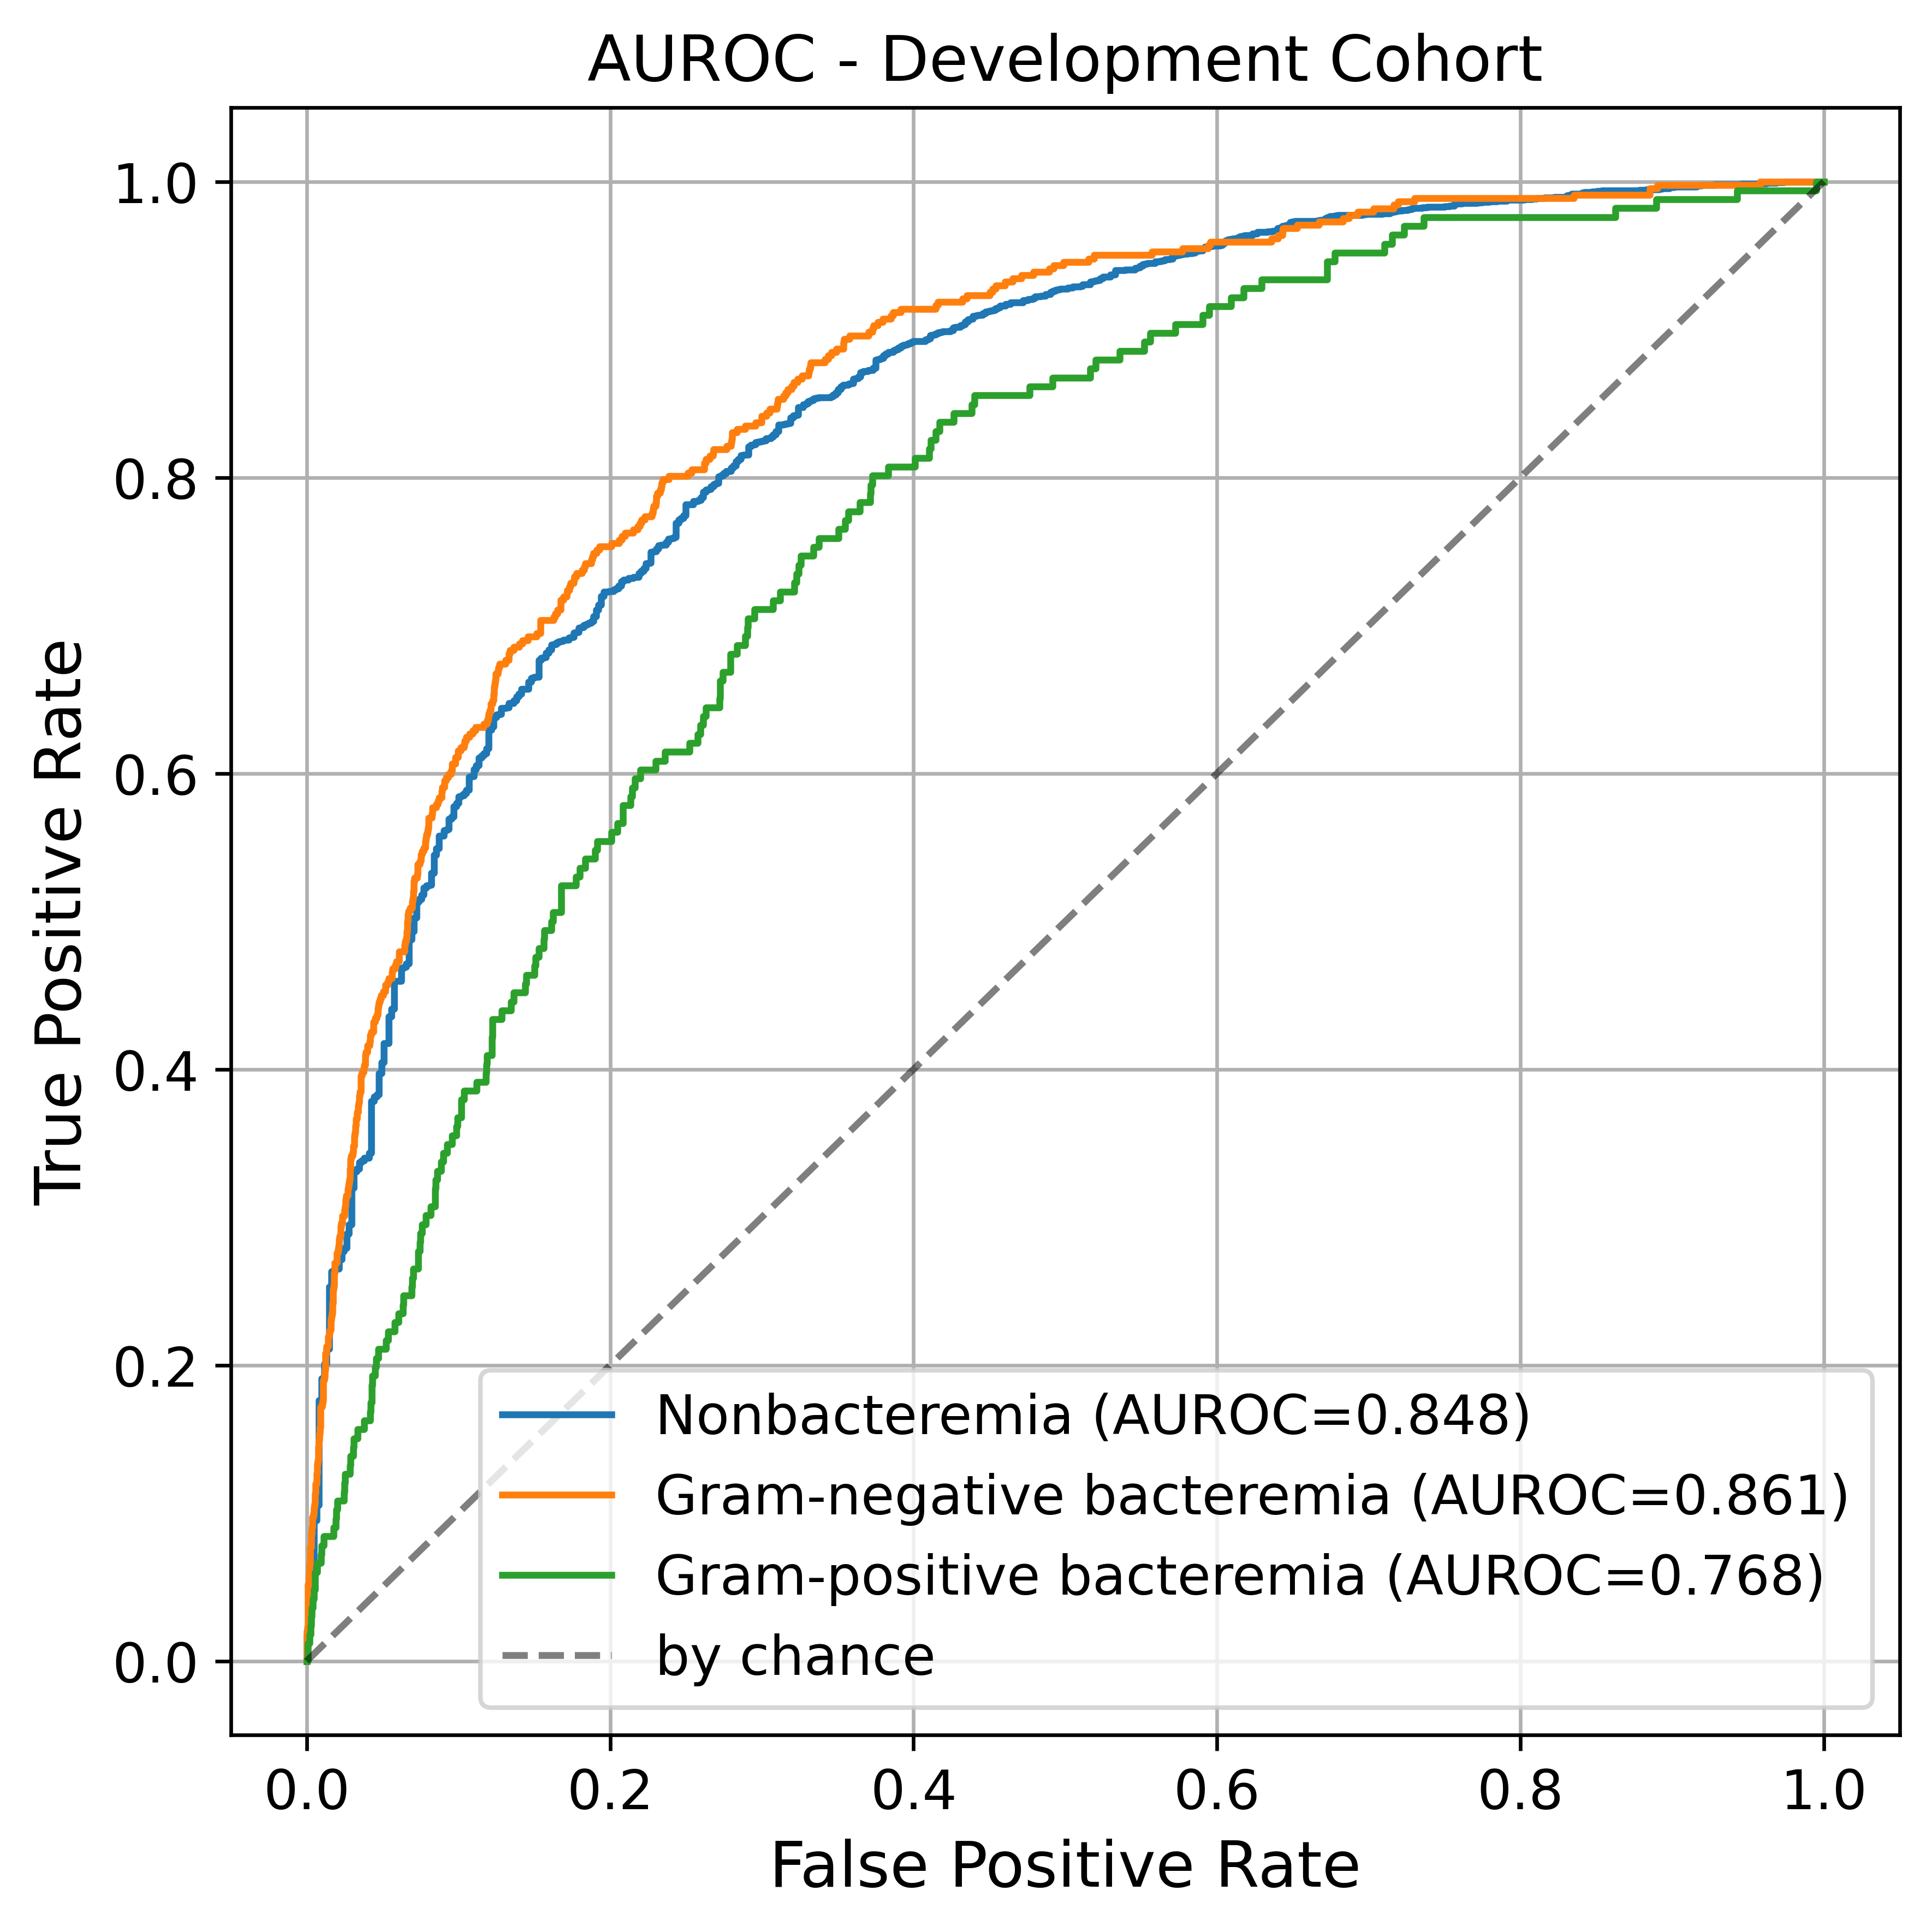

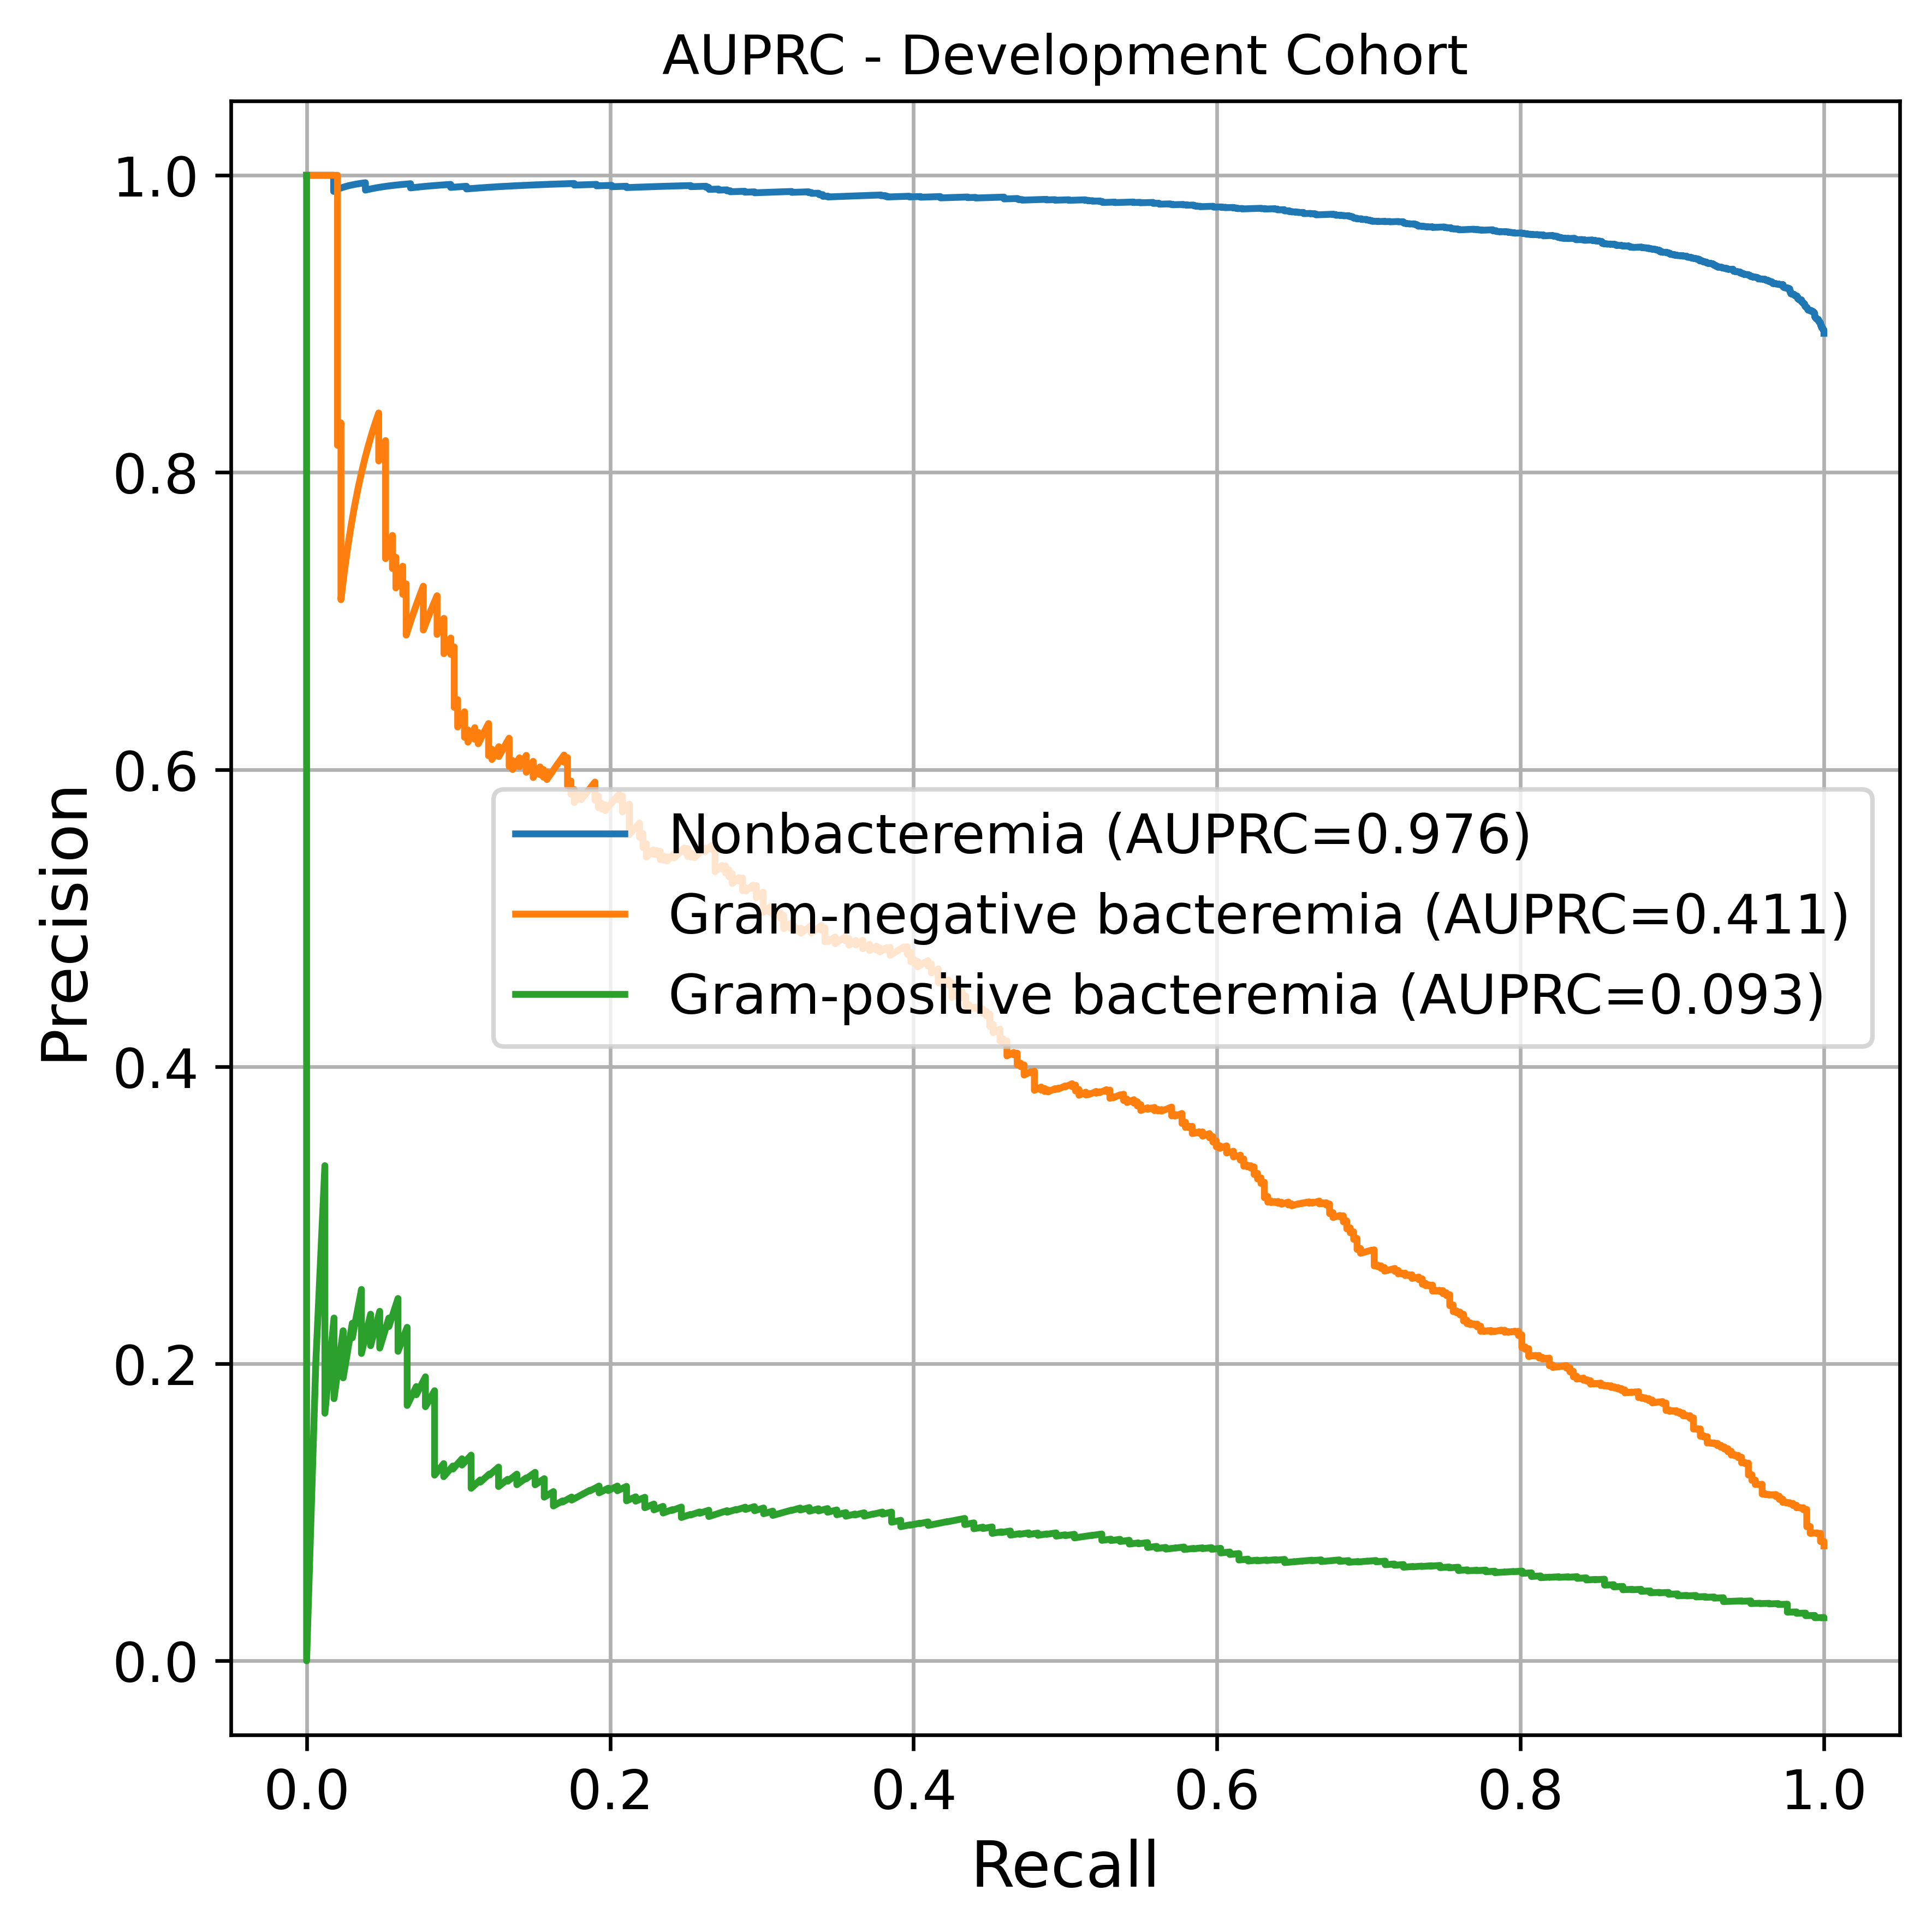

In [3]:
data = load(os.path.join(cache_dir, "plotting_data.pkl"))

y_all_dic = data["y_"]
y_probs_dic = data["y_probs_dic"]

y_val = y_all_dic["CMUH development"]
y_prob = y_probs_dic["CMUH development"]

class_names = ['Nonbacteremia', 'Gram-negative bacteremia', 'Gram-positive bacteremia']

plot_multiclass_roc(y_val, y_prob, class_names)
plot_multiclass_prc(y_val, y_prob, class_names)


#### **Calibration**

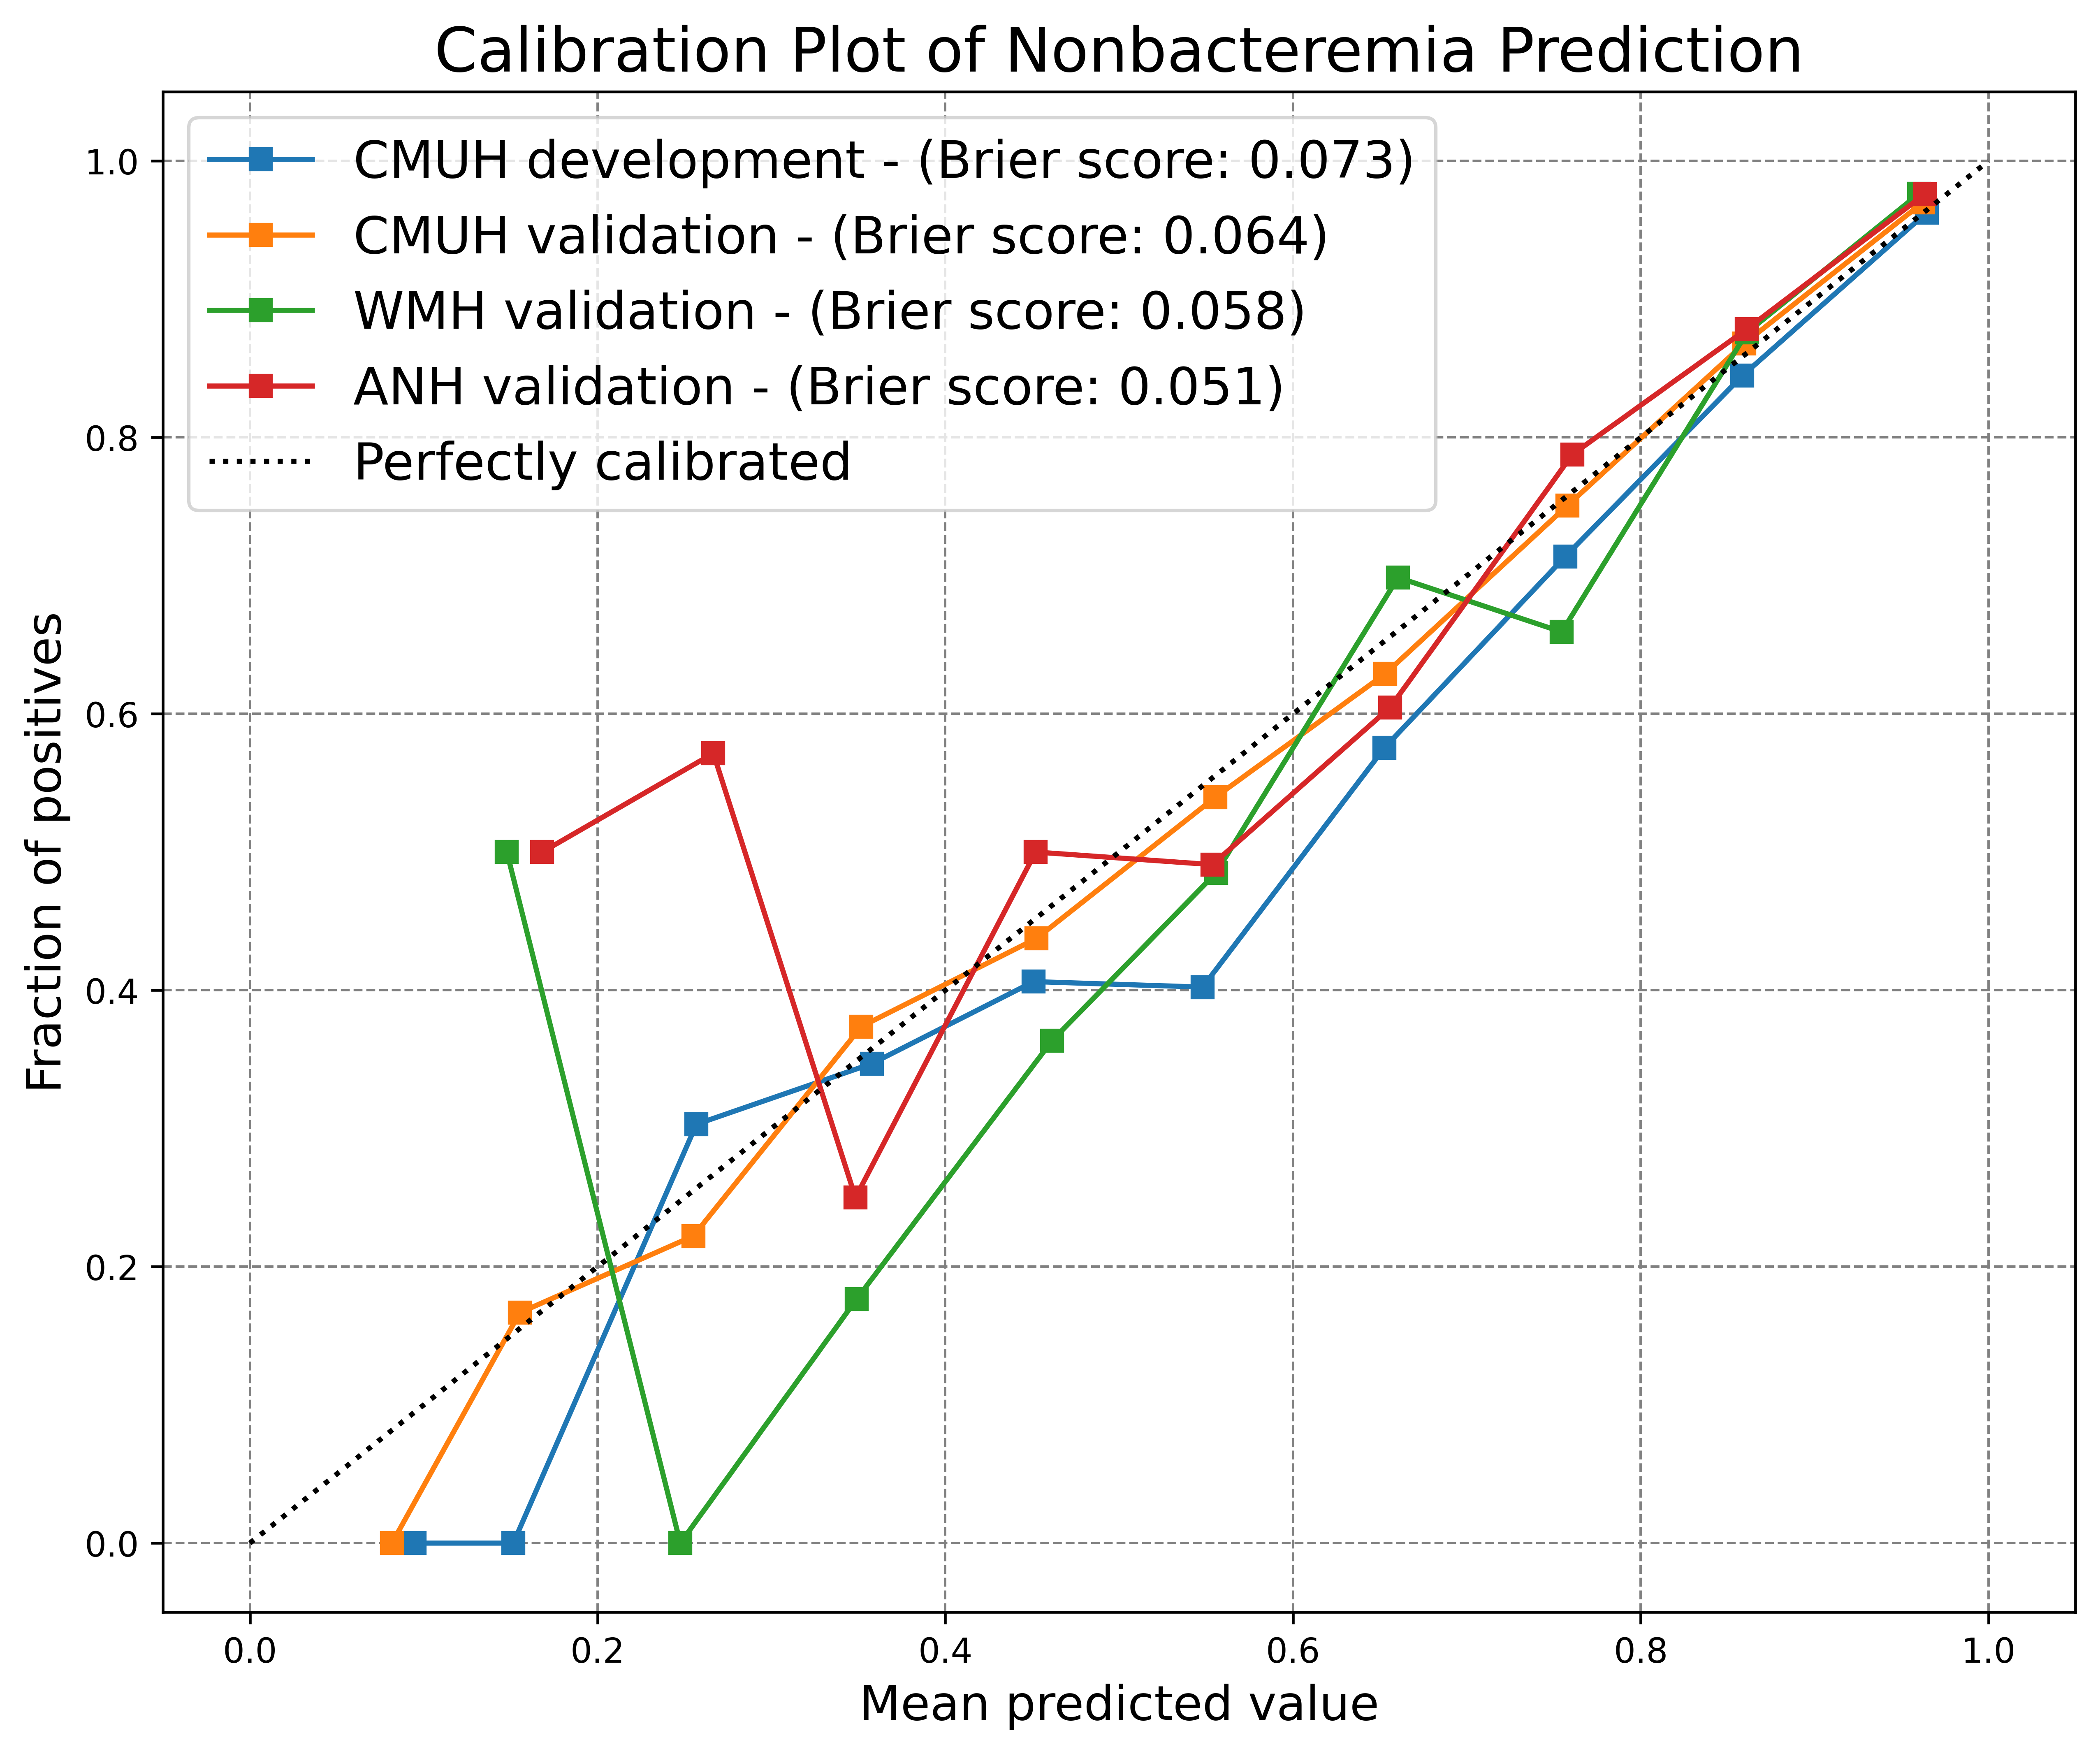

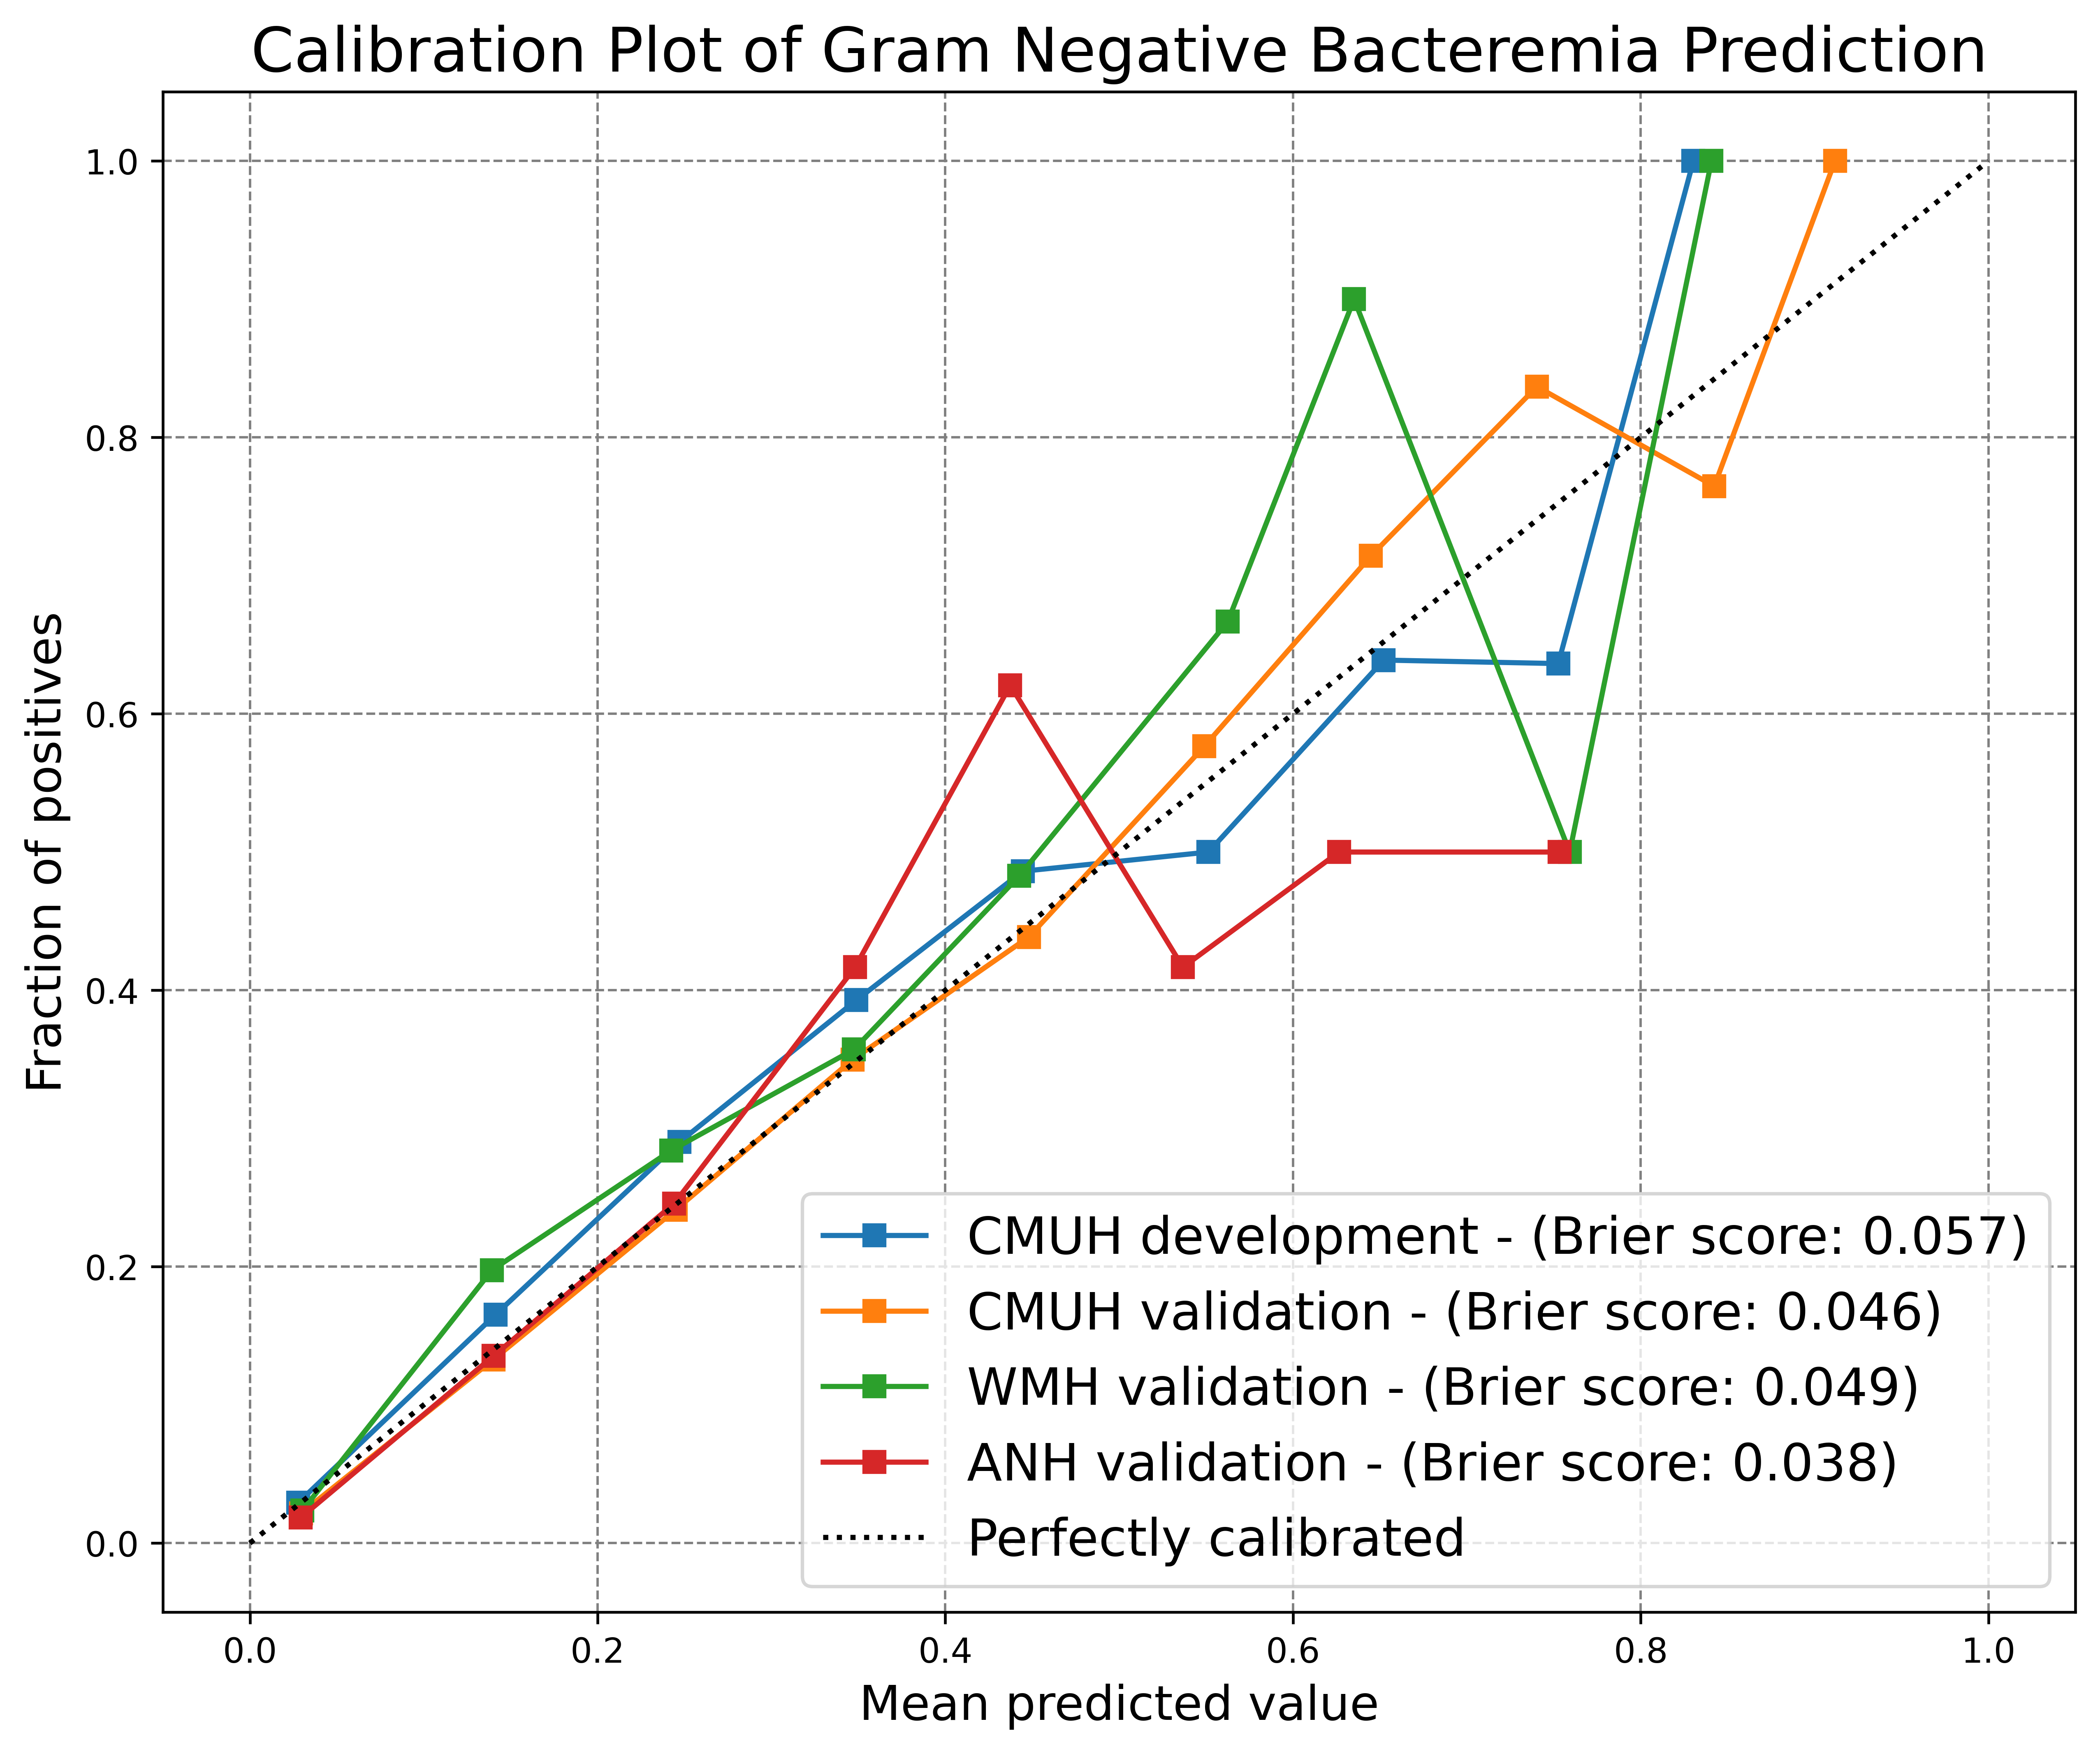

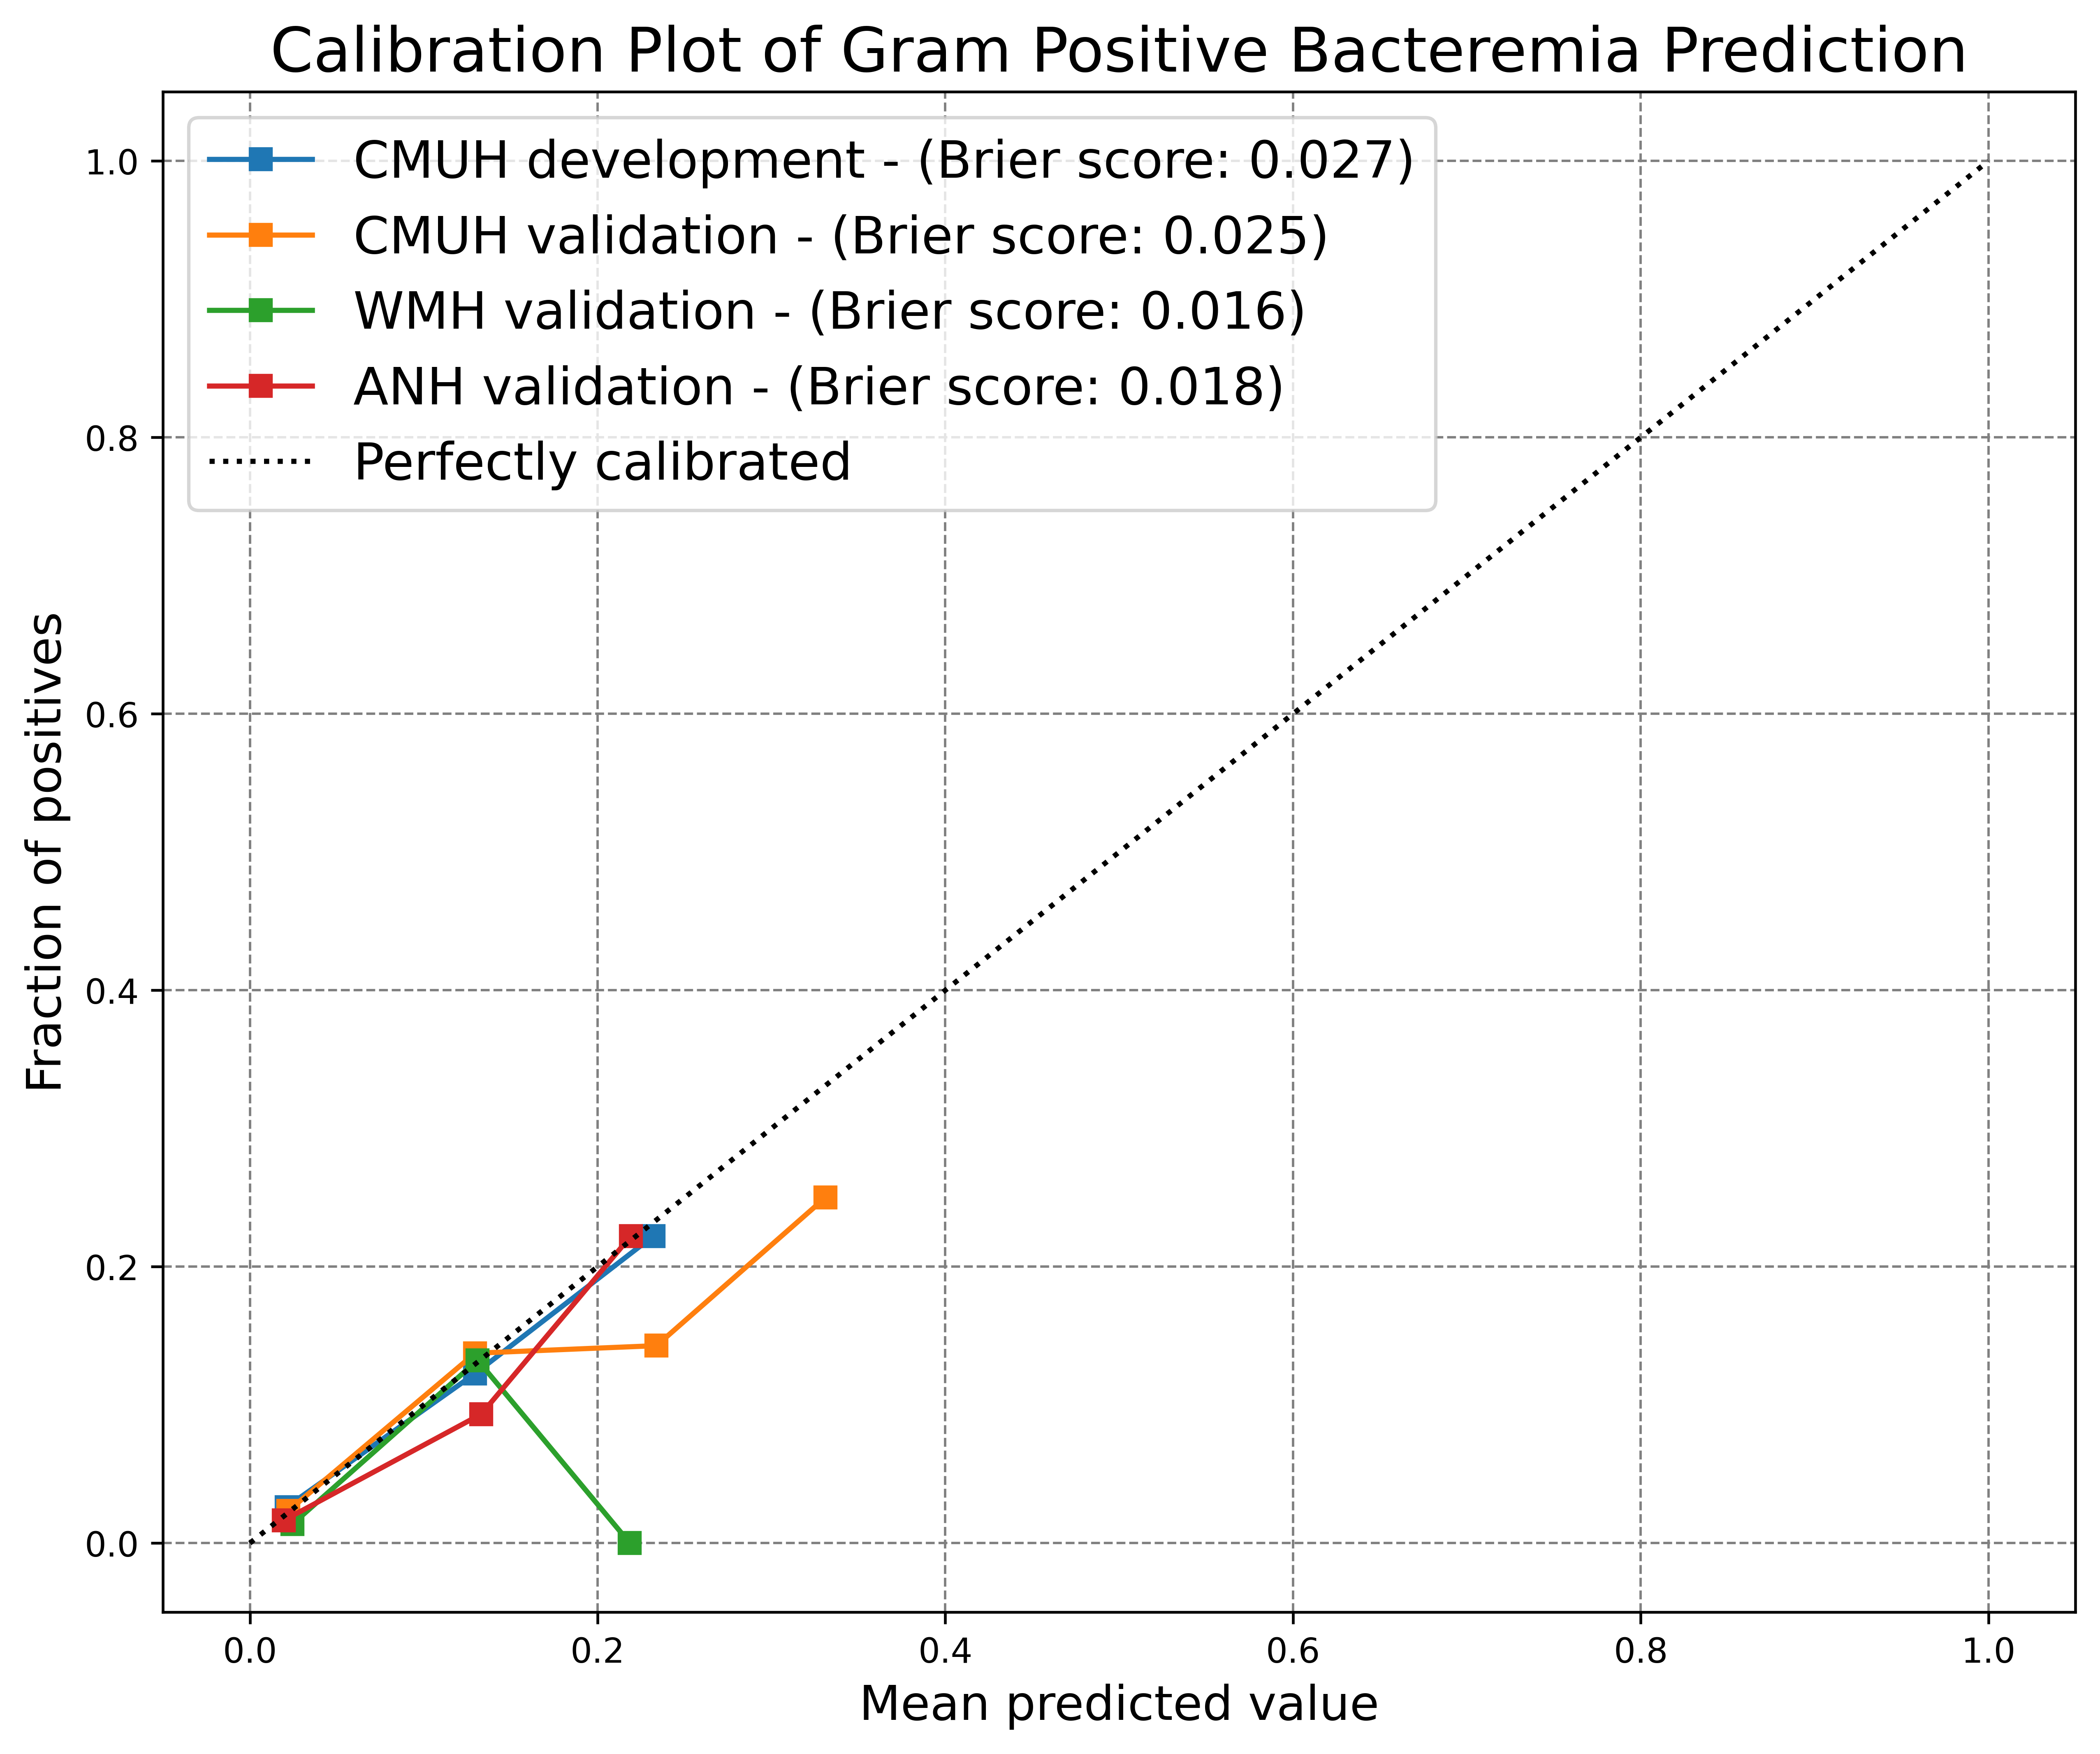

In [4]:
data = load(os.path.join(cache_dir, "evaluation_data.pkl"))
y_bins = data["y_bins"]
y_probs = data["y_probs"]
labels = data["labels"]

plot_combined_calibration_curve(y_bins, y_probs, labels, num_classes=3)